# ***Задача 3*** 
***Условие***

Рассматривается система ОДУ, описывающая реакции фотохимии озона в
атмосфере:

\begin{cases}
    c_1' =  k_1c_3 - k_2c_1\\
    c_2' = k_1c_3 - k_3c_2c_4\\
    c_3' = k_3c_2c_4 - k_1c_3\\
    c_4' = k_2c_1 - k_3c_2c_4
\end{cases}

$$\bar c(0) = (0, 0, 5\cdot 10^{11}, 8\cdot 10^{11})$$

где  $𝑐 = (𝑐1 , 𝑐2 , 𝑐3 , 𝑐4 )^𝑇$ – концентрации (кол-во молекул вещества в кубическом сантиметре) $𝑂$, $𝑁𝑂$, $𝑁𝑂_2$ и $𝑂_3$ . Выражения для коэффициентов реакций:

$$𝑘_1 = 10^{-2} max [0, sin(\frac{2 \pi t}{t_d} )] s^{-1} $$
$$𝑘_2 = 10^5 𝑠^{−1} , \quad  𝑘_3 = 10^{−16} cm^3 \cdot molecule^{−1} \cdot s^{−1},  \quad 𝑡_𝑑 = 24 · 60 · 60 s$$

***Решение***

1) Найдем численное решение при помощи НМРК.

Пока код выдает лажу.

<ipython-input-4-1b65aec97fee>:62: RuntimeWarning: overflow encountered in double_scalars
  a_3 = k[2]*c[1]*c[3]
<ipython-input-4-1b65aec97fee>:76: RuntimeWarning: invalid value encountered in multiply
  val_mid.append(val + h * sum([a[j][k] * func(val_mid[k], t_mid[k]) for k in range(j)]))
<ipython-input-4-1b65aec97fee>:64: RuntimeWarning: invalid value encountered in double_scalars
  return np.copy(np.array([a_1 - a_2, a_1 - a_3, a_3 - a_1, a_2 - a_3]))


ValueError: Axis limits cannot be NaN or Inf

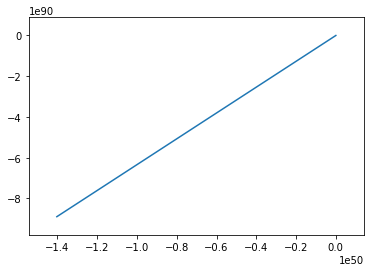

In [4]:
from scipy.optimize import fsolve
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Вспомогательная функция
def scal_prod(x, y):
    if len(x) != len(y):
        raise
    return sum([x[i]*y[i] for i in range(len(x))])


def implicit_runge_kutt(a, b, c, n, start, finish, start_val, func):
    h = (finish - start) / n
    val = np.copy(start_val)
    t = start
    for i in range(n):
        val_mid = [val] # промежуточные значения функции
        t_mid = [t] # промежуточные значения времени
        for j in range(1, len(b)):
            t_mid.append(t + c[j] * h)
            const1 = val + h * sum([a[j][k] * func(val_mid[k], t_mid[k]) for k in range(j)])
            # print("const:", const1)
            def equation(x):
                return x - func(x, t + c[j] * h) * a[j][j] - const1
            slve = fsolve(equation, x0=val)
            print(f"solve: {slve}, solve_prec: {slve - func(slve, t + c[j] * h) * a[j][j] - const1}")
            val_mid.append(np.copy(slve))
        t += h
        dif = [func(val_mid[k], t_mid[k]) for k in range(len(b))]
        # print("bubu: ", h, scal_prod(b, dif))
        val += h * scal_prod(b, dif)
        print(f"time: {t}")
        print(f"dif: {dif}")
        print("val: ", val)
    return val


def euler_method(n, start, finish, srart_val, func):
    h = (finish - start) / n
    val = np.copy(srart_val)
    t = start
    for i in range(n):
        val += h * func(val, t)
        print(f"time: {t}")
        print("val: ", val)
        t += h
    return val


def k_1(t):
    return 0.01 * max(0, math.sin(2*math.pi*t/(24*60*60)))

k = [k_1, 10**5, 10**(-16)]


def func2(c, t):
    a_1 = k[0](t)*c[2]
    a_2 = k[1] * c[0]
    a_3 = k[2]*c[1]*c[3]
    # print(a_1, a_2, a_3)
    return np.copy(np.array([a_1 - a_2, a_1 - a_3, a_3 - a_1, a_2 - a_3]))

def explicit_runge_kutt_animated(a, b, c, n, h, start, start_val, func):
    # print("pace is: ", h)
    val = np.copy(start_val)
    vals = [np.copy(val)]
    t = start
    for i in range(n):
        val_mid = [val]
        t_mid = [t]
        for j in range(1, len(b)):
            t_mid.append(t + c[j] * h)
            val_mid.append(val + h * sum([a[j][k] * func(val_mid[k], t_mid[k]) for k in range(j)]))
        t += h
        dif = [func(val_mid[k], t_mid[k]) for k in range(len(b))]
        vals.append(np.copy(val))
        val += h * scal_prod(b, dif)

    def animate(frame):
        if frame == 0:
            x_side = max([abs(vals[i][0]) for i in range(len(vals))])
            y_side = max([abs(vals[i][1]) for i in range(len(vals))])
            ax.set_ylim(-y_side * 1,5, y_side * 1,5)
            ax.set_xlim(-x_side * 1,5, x_side * 1,5)
            line.set_ydata([-y_side, y_side])
            line.set_xdata([-x_side, x_side])
            return line,

        x = np.array([vals[i][0] for i in range(frame + 2)])
        y = np.array([vals[i][1] for i in range(frame + 2)])
        line.set_ydata(y)
        line.set_xdata(x)

        # Меняем пределы осей (пример: подстраиваем под текущий максимум и минимум)
        y_min = np.min(y)
        y_max = np.max(y)
        padding = 0.1 * (y_max - y_min)  # Небольшой отступ сверху и снизу
        ax.set_ylim(y_min - padding, y_max + padding) #Установка пределов

        x_min = np.min(x)
        x_max = np.max(x)
        padding = 0.1 * (x_max - x_min)  # Небольшой отступ сверху и снизу
        ax.set_xlim(x_min - padding, x_max + padding) #Установка пределов

        return line,  # Важно: возвращаем изменяемый объект (line,)

    fig, ax = plt.subplots()
    x_side = max([abs(vals[i][0]) for i in range(len(vals))])
    y_side = max([abs(vals[i][1]) for i in range(len(vals))])
    line, = ax.plot([-x_side, x_side], [-y_side, y_side])  # Инициализируем линию графика
    ani = animation.FuncAnimation(fig, animate, frames=n, blit=True, repeat=False, interval=20)
    HTML(ani.to_jshtml())
    plt.show()

# a = [
#      [1, 0, 0],
#      [0, 1/3, 1],
#      [-1/12, 3/4, 1/3]
# ]
# b = [-1/12, 3/4, 1/3]
# c = [1, 1/3, 1]

a = [
     [0, 0, 0, 0],
     [0.5, 0, 0, 0],
     [0, 0.5, 0, 0],
     [0, 0, 1, 0]
 ]
b = [1/6, 1/3, 1/3, 1/6]
c = [0, 0.5, 0.5, 1]

T = 24 * 60 * 60.0
start_val = np.array([0.0, 0.0, 5e11, 8e11], dtype=np.float64)
steps = 10000

animation_html = explicit_runge_kutt_animated(a, b, c, 1000, T / 1000, 0, start_val, func2)
animation_html
# print(euler_method(steps, 0, T * 2, start_val, func2))